In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

### 포지셔널 행렬 구현

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### Scaled dot product attention

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### Multi-head attention

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value) 

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### Padding masking

In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### Look ahead masking

In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### Encoder

In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


### Decoder

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 데이터 받아오기

In [11]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("data/ChatbotData.csv")

# 각각 저장
df["Q"].to_csv("data/question.txt", index=False, header=False)
df["A"].to_csv("data/answer.txt", index=False, header=False)
df["label"].to_csv("data/label.txt", index=False, header=False)


FileNotFoundError: [Errno 2] No such file or directory: 'data/ChatbotData.csv'

In [12]:
import os

# 현재 디렉토리 출력
print("현재 작업 디렉토리:", os.getcwd())

# data 폴더가 존재하는지 확인
print("data 폴더 존재 여부:", os.path.exists("data"))

# data 폴더 안의 파일 목록 출력
if os.path.exists("data"):
    print("data 폴더 내부 파일 목록:", os.listdir("data"))


현재 작업 디렉토리: /aiffel/aiffel/transformer_chatbot
data 폴더 존재 여부: True
data 폴더 내부 파일 목록: ['ChatbotData .csv', 'answer.txt', 'label.txt', 'question.txt']


오류가 나서 보니 ChatbotData 파일명에 공백이 포함되어 있었다 ...

In [13]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("data/ChatbotData .csv")

# 각각 저장
df["Q"].to_csv("data/question.txt", index=False, header=False)
df["A"].to_csv("data/answer.txt", index=False, header=False)
df["label"].to_csv("data/label.txt", index=False, header=False)


In [14]:
base_path = os.path.abspath("data")

# 저장된 파일 경로 출력
question_path = os.path.join(base_path, "question.txt")
answer_path = os.path.join(base_path, "answer.txt")
label_path = os.path.join(base_path, "label.txt")

In [15]:
print(len(df))

11823


데이터가 그리 크지는 않아서 따로 샘플 최대 개수를 설정하지는 않겠습니다

### 전처리 함수
한글 데이터이므로 기존 전처리 함수에서
- 소문자 변경 삭제
- 한글 정규식 범위 추가

In [16]:
def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()

    # 구두점(?.!,) 앞뒤에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 연속된 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)

    # 한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence)

    # 최종 공백 제거
    sentence = sentence.strip()

    return sentence

In [17]:
# 데이터 로드 및 전처리 함수

# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수

def load_conversations():
    # CSV 데이터 로드
    df = pd.read_csv("data/ChatbotData .csv")

    # Q: 질문, A: 답변을 리스트로 저장
    inputs = df["Q"].tolist()
    outputs = df["A"].tolist()

    # 전처리 적용
    inputs = [preprocess_sentence(q) for q in inputs]
    outputs = [preprocess_sentence(a) for a in outputs]

    return inputs, outputs

# 함수 실행
questions, answers = load_conversations()
print('전체 샘플 수:', len(questions))
print('전체 샘플 수:', len(answers))


전체 샘플 수: 11823
전체 샘플 수: 11823


In [18]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [19]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 병렬 데이터 전처리

### 단어장 만들기

In [20]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [21]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [22]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]


In [23]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8166


### 각 단어를 고유한 정수로 인코딩 & 패딩

In [24]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 610, 2488, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6269, 97, 1]


In [25]:
# 문장 길이 계산 (문자 개수 기준)
max_q_length = max(len(q) for q in questions)
max_a_length = max(len(a) for a in answers)

print(f"질문(Q) 최대 길이 (문자 수 기준): {max_q_length}")
print(f"답변(A) 최대 길이 (문자 수 기준): {max_a_length}")


질문(Q) 최대 길이 (문자 수 기준): 57
답변(A) 최대 길이 (문자 수 기준): 78


In [26]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [27]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [28]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8166
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 교사 강요 사용

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 모델 정의 및 학습

### 트랜스포머 함수 정의

In [30]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


### 모델 생성

In [62]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수
D_MODEL = 768 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 12 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 768)    31496704    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수

In [63]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


### 커스텀 된 학습률

In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=8000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

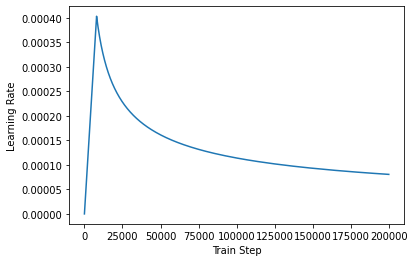

In [65]:
sample_learning_rate = CustomSchedule(d_model=768)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [66]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [67]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 108s 460ms/step - loss: 1.3776 - accuracy: 0.0204
Epoch 2/30
185/185 [==============================] - 85s 459ms/step - loss: 1.1896 - accuracy: 0.0252
Epoch 3/30
185/185 [==============================] - 85s 459ms/step - loss: 1.0784 - accuracy: 0.0425
Epoch 4/30
185/185 [==============================] - 85s 460ms/step - loss: 1.0218 - accuracy: 0.0497
Epoch 5/30
185/185 [==============================] - 85s 459ms/step - loss: 0.9913 - accuracy: 0.0501
Epoch 6/30
185/185 [==============================] - 85s 459ms/step - loss: 0.9644 - accuracy: 0.0507
Epoch 7/30
185/185 [==============================] - 85s 459ms/step - loss: 0.9453 - accuracy: 0.0513
Epoch 8/30
185/185 [==============================] - 85s 459ms/step - loss: 0.9296 - accuracy: 0.0520
Epoch 9/30
185/185 [==============================] - 85s 459ms/step - loss: 0.9156 - accuracy: 0.0526
Epoch 10/30
185/185 [==============================] - 85s 460ms/step - 

## 챗봇 테스트

### decoder_inference

In [41]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


In [42]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


### 임의 문장 test 1

기본 코드로 학습시킨 결과  
첫 질문은 반대의 대답을 하고 두 번째 질문은 말이 되는 듯 하다  

[전처리]    
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수    
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.1 # 드롭아웃의 비율   
EPOCHS = 10   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 20000

In [57]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 직접 물어보세요 .


'직접 물어보세요 .'

In [55]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 잘 될 거예요 .


'잘 될 거예요 .'

### 임의 문장 test 2

교사 강요에서 BUFFER_SIZE 만 5000으로 수정한 결과  
전 보다는 어느 정도 말이 되긴 하지만 그래도 아직 부족하다  
acc도 0.06 대  
  
[전처리]    
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수    
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.1 # 드롭아웃의 비율   
EPOCHS = 10   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 5000

In [70]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 좋아하는 마음을 대화를 해보세요 .


'좋아하는 마음을 대화를 해보세요 .'

In [71]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 좋은 사람 만날 수 있을 거예요 .


'좋은 사람 만날 수 있을 거예요 .'

In [72]:
sentence_generation('혼자 노력하는 연애인 거 같아.')

입력 : 혼자 노력하는 연애인 거 같아.
출력 : 마음이 복잡하겠어요 .


'마음이 복잡하겠어요 .'

In [73]:
sentence_generation('크리스마스인데 만나자고 해도 됨?')

입력 : 크리스마스인데 만나자고 해도 됨?
출력 : 좋아하는 마음을 대화를 해보세요 .


'좋아하는 마음을 대화를 해보세요 .'

In [74]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 좋은 사람 만날 수 있을 거예요 .


'좋은 사람 만날 수 있을 거예요 .'

In [75]:
sentence_generation('나 심심해.')

입력 : 나 심심해.
출력 : 좋은 사람 만날 수 있을 거예요 .


'좋은 사람 만날 수 있을 거예요 .'

In [76]:
sentence_generation('오늘 저녁 뭐 먹을까?')

입력 : 오늘 저녁 뭐 먹을까?
출력 : 좋은 곳으로 될 거예요 .


'좋은 곳으로 될 거예요 .'

### 임의 문장 test 3

lr의 d_model 과 동일하게 128로 맞춤  
드롭아웃도 0.5로 키우고  
교사 강요 batch_size도 16으로 줄였다  
결과는 ..... 처참합니다    
그리고 BUFFER SIZE 관련해서 영진님께서 캐시에 있는 데이터를 버퍼에서 셔플하여 데이터의 편향을 막으려고 사용한 것이므로    
5000개만 데이터를 섞게 되면 편향이 생길 수 있다는 의견을 공유해주셨다    
확실히 결과를 보면 그런 것 같다  
따라서 다음 test에는 다시 20000으로 복귀..   

[전처리]   
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.5 # 드롭아웃의 비율   
EPOCHS = 10   
(교사 강요)   
BATCH_SIZE = 16   
BUFFER_SIZE = 5000   

In [88]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 


'좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 '

In [89]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 


'좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 '

### 임의 문장 test 4

교사 강요 파라미터를 다시 원복하고 에폭만 20으로 늘려봤다  
Epoch 20/20
185/185 [==============================] - 15s 82ms/step - loss: 0.7520 - accuracy: 0.0595   
잘 되길 바랄게요 앵무새가 됐다  

[전처리]   
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.5 # 드롭아웃의 비율   
EPOCHS = 20   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 20000   

In [99]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 그런 사람 만나길 바랄게요 .


'그런 사람 만나길 바랄게요 .'

In [100]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 잘 되길 바랄게요 .


'잘 되길 바랄게요 .'

In [101]:
sentence_generation('크리스마스인데 만나자고 해도 됨?')

입력 : 크리스마스인데 만나자고 해도 됨?
출력 : 사람마다 사람 솔직하 수도 있어요 .


'사람마다 사람 솔직하 수도 있어요 .'

In [102]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 잘 되길 바랄게요 .


'잘 되길 바랄게요 .'

In [103]:
sentence_generation('나 심심해.')

입력 : 나 심심해.
출력 : 잘 되길 바랄게요 .


'잘 되길 바랄게요 .'

### 임의 문장 test 5

d_model을 lr, model 모두 256으로 맞춤   
드롭아웃 0.3   
Epoch 20/20
185/185 [==============================] - 22s 118ms/step - loss: 0.6597 - accuracy: 0.0658   
표현이 좀 더 다양해진 것 같다

[전처리]   
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.3 # 드롭아웃의 비율   
EPOCHS = 20   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 20000   

In [43]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 좋아하는 감정을 후유증이 있기 아니라 만나세요 .


'좋아하는 감정을 후유증이 있기 아니라 만나세요 .'

In [44]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 좋은 만남이었길 바라요 .


'좋은 만남이었길 바라요 .'

In [45]:
sentence_generation('크리스마스인데 만나자고 해도 됨?')

입력 : 크리스마스인데 만나자고 해도 됨?
출력 : 사람마다 필요한 거 같아요 .


'사람마다 필요한 거 같아요 .'

In [46]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 맛있게 드세요 .


'맛있게 드세요 .'

In [47]:
sentence_generation('나 심심해.')

입력 : 나 심심해.
출력 : 맛있게 드세요 .


'맛있게 드세요 .'

In [48]:
sentence_generation('오늘 저녁 뭐 먹을까?')

입력 : 오늘 저녁 뭐 먹을까?
출력 : 맛있게 드세요 .


'맛있게 드세요 .'

### 임의 문장 test 6

d_model을 lr, model 모두 512로 맞춤   
드롭아웃 0.3   
epochs = 30  
Epoch 30/30
185/185 [==============================] - 40s 217ms/step - loss: 0.5576 - accuracy: 0.0729   
문장이 어색한 건 없지만 질문에 대답이 맞는지는 잘 모르겠다  

[전처리]   
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수   
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.3 # 드롭아웃의 비율   
EPOCHS = 30   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 20000   

In [53]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 금방 지나갈 거예요 .


'금방 지나갈 거예요 .'

In [54]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 많이 시간이 흘렀네요 .


'많이 시간이 흘렀네요 .'

In [55]:
sentence_generation('크리스마스인데 만나자고 해도 됨?')

입력 : 크리스마스인데 만나자고 해도 됨?
출력 : 먼저 물어보세요 .


'먼저 물어보세요 .'

In [56]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 저도 듣고 싶네요 .


'저도 듣고 싶네요 .'

In [57]:
sentence_generation('나 심심해.')

입력 : 나 심심해.
출력 : 저도 듣고 싶네요 .


'저도 듣고 싶네요 .'

In [58]:
sentence_generation('오늘 저녁 뭐 먹을까?')

입력 : 오늘 저녁 뭐 먹을까?
출력 : 이렇게 고민하게 만들려고 그랬나봐요 .


'이렇게 고민하게 만들려고 그랬나봐요 .'

### 임의 문장 test 7

d_model을 lr, model 모두 768로 맞춤   
num_layer를 8로 증가, num_heads 를 12로 증가   
lr - warmup_steps=4000 -> 8000 으로 증가

막상 훈련을 돌리고 보니 데이터가 적은편인데 너무 과하게 파라미터를 설정한 것 같다  

Epoch 30/30
185/185 [==============================] - 85s 459ms/step - loss: 0.7089 - accuracy: 0.0601   

역시나 너무 과했던 것 같다  

[전처리]   
기본 전처리   
두점(?.!,) 앞뒤에 공백 추가   
연속된 공백을 하나의 공백으로 변환   
한글, 영어, 숫자, 기본적인 특수문자(?.!,)만 허용하고 나머지는 공백 처리   

[하이퍼파라미터]   
NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수   
D_MODEL = 768 # 인코더와 디코더 내부의 입, 출력의 고정 차원   
NUM_HEADS = 12 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기   
DROPOUT = 0.3 # 드롭아웃의 비율   
EPOCHS = 30   
(교사 강요)   
BATCH_SIZE = 64   
BUFFER_SIZE = 20000   

In [68]:
sentence_generation('흑기사 해주는 짝남.')

입력 : 흑기사 해주는 짝남.
출력 : 저도 좀 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 


'저도 좀 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 곳으로 '

In [69]:
sentence_generation('나 헤어졌어.')

입력 : 나 헤어졌어.
출력 : 많이 많이 많이 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 


'많이 많이 많이 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 '

### 회고
실험을 더 해봐야겠지만 현재로써는 5, 6 번이 그나마 결과가 가장 나은 것 같습니다.   
아무래도 데이터 양이 많지 않아서 결과가 계속 아쉽게 나오는 것 같습니다.   
나중에 더 큰 데이터로도 한 번 수행해보고 싶습니다.   
또한 실험을 수행하면서 트렌스포머 구조에 대한 개념이 계속 헷갈려서 정리가 필요할 것 같습니다.   
그래도 오늘은 저번보다는 많은 실험을 할 수가 있어 좋았습니다.   